In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, plot
import cv2

import json

In [2]:
use_GPU = core.use_gpu()
print(f'>>> GPU activated? {["NO", "YES"][use_GPU]}')

>>> GPU activated? YES


In [3]:
image_path = '/home/KutumLabGPU/Documents/santosh/capstone_project/models/snake_algo_implement/TCGA-WSI-patch.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

In [4]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

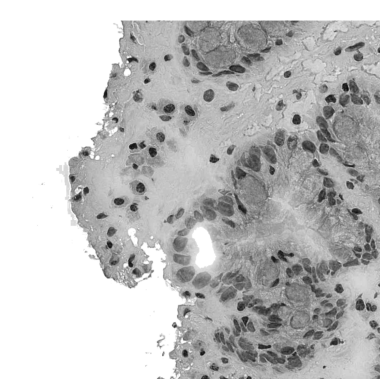

In [5]:
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
imgs = [img]

##### cellpose model : nuclei OR cyto3

In [7]:
# Use the 'nuclei' model for nuclear segmentation
model = models.Cellpose(gpu=use_GPU, model_type='cyto3')

In [8]:
channels = [0, 0]
diameter = 30

# Segmentation
masks_pred, flows, styles, diams = model.eval(
    imgs,
    diameter=diameter,
    channels=channels,
    flow_threshold=0.5,  # Adjust if segmentation is too strict or lenient
    cellprob_threshold=0.0  # Adjust if too many/few nuclei are detected
)

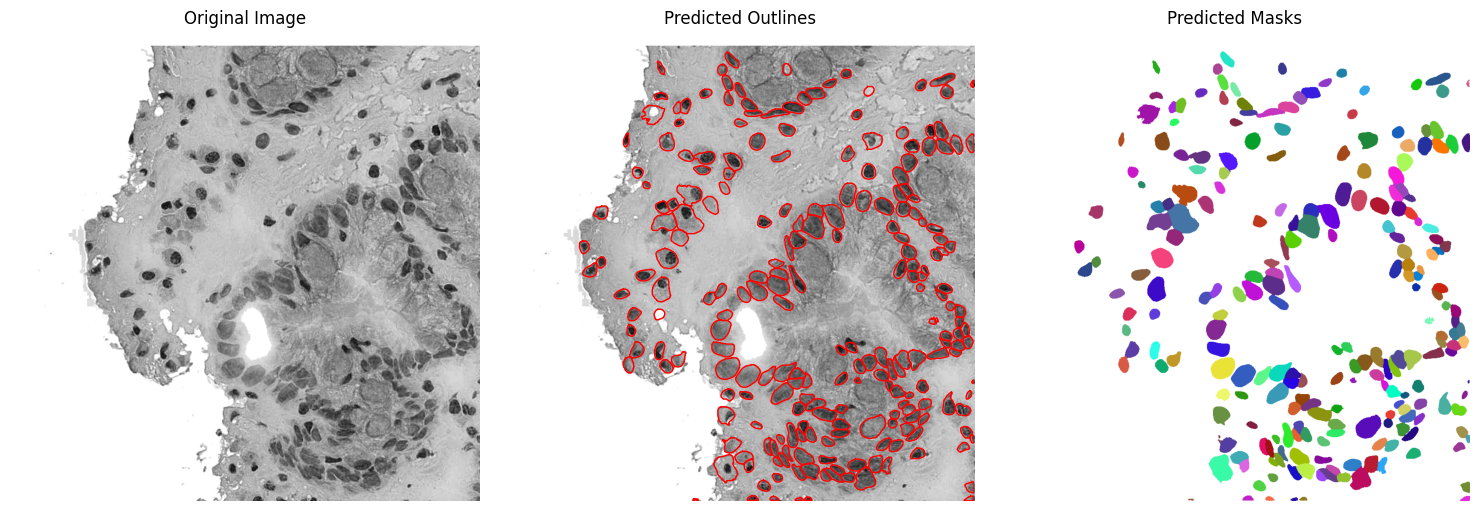

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imgs[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Predicted outlines
outlines_pred = utils.outlines_list(masks_pred[0])
plt.subplot(1, 3, 2)
plt.imshow(imgs[0], cmap='gray')
for o in outlines_pred:
    plt.plot(o[:, 0], o[:, 1], color='r', lw=1)  # Red outlines
plt.title('Predicted Outlines')
plt.axis('off')

# Predicted masks
plt.subplot(1, 3, 3)
mask_rgb = plot.mask_rgb(masks_pred[0])  
plt.imshow(mask_rgb)
plt.title('Predicted Masks')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Save the image with predicted outlines
plt.figure(figsize=(5, 5))
plt.imshow(imgs[0], cmap='gray')
for o in outlines_pred:
    plt.plot(o[:, 0], o[:, 1], color='r', lw=1)  # Red outlines
plt.title('Cellpose')
plt.axis('off')
plt.savefig('predicted_outlines.png', bbox_inches='tight', dpi=300)  # Save the image
plt.close() 

#### Extract GeoJSON Coordinates of the Segmentation

In [11]:
# GeoJSON structure
geojson_data = {
    "type": "FeatureCollection",
    "features": []
}

for idx, outline in enumerate(outlines_pred):
    coords = outline.tolist()  
    coords.append(coords[0])
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [coords]  
        },
        "properties": {
            "id": idx + 1  
        }
    }
    geojson_data["features"].append(feature)

with open('segmented_nuclei.geojson', 'w') as f:
    json.dump(geojson_data, f, indent=2)

print(f"GeoJSON coordinates saved to 'segmented_nuclei.geojson")

GeoJSON coordinates saved to 'segmented_nuclei.geojson


#### Overlay the coordinates on original patch

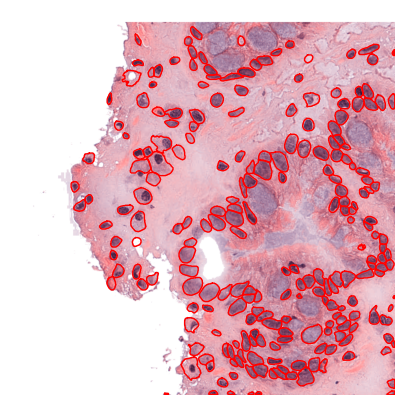

RGB image with outlines saved to 'rgb_image_with_outlines.png'


In [12]:
img_rgb = cv2.imread(image_path)  
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)  

with open('segmented_nuclei.geojson', 'r') as f:
    geojson_data = json.load(f)

outlines = []
for feature in geojson_data['features']:
    coords = feature['geometry']['coordinates'][0][:-1]  
    outlines.append(coords)

plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)  
for outline in outlines:
    x_coords = [point[0] for point in outline]
    y_coords = [point[1] for point in outline]
    plt.plot(x_coords, y_coords, color='r', lw=1)  
plt.axis('off')

plt.savefig('rgb_image_with_outlines.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print("RGB image with outlines saved to 'rgb_image_with_outlines.png'")